In [199]:
import pandas as pd
import numpy as np
from datetime import timedelta

In [200]:
pd.set_option('display.max_rows', 100)

In [201]:
df_dem = pd.read_csv("../archive/Demographics/demographics.csv")
df_survey = pd.read_csv("../archive/all_student_ema_data_cleaned (1).csv")
df_sens = pd.read_csv("../archive/Sensing/sensing.csv")

In [202]:
df_survey['day'] = pd.to_datetime(df_survey['day'], format='%Y%m%d')
df_sens['day'] = pd.to_datetime(df_sens['day'], format='%Y%m%d')
df_survey = df_survey.drop(columns=['Unnamed: 0'])

In [203]:
cols = [
    'uid',
    'day',
    'is_ios',
    # physical
    'act_on_foot_ep_0',
    'act_running_ep_0',
    'act_walking_ep_0',
    'loc_study_dur',
    'loc_home_dur',
    'loc_workout_dur',
    # social
    'act_in_vehicle_ep_0',
    'loc_dist_ep_0',
    'loc_social_dur',
    'loc_food_dur',
    'loc_visit_num_ep_0',
    'loc_social_unlock_duration',
    'loc_food_unlock_duration',
    'loc_social_unlock_num',
    'loc_food_unlock_num',
    'loc_social_still',
    'loc_food_still',
    # sleep
    'sleep_duration',
    'sleep_start',
    'sleep_end',
]
df_sens = df_sens[cols].copy()

In [204]:
def sum_skipna(row, col1, col2):
    if np.isnan(row[col1]) and np.isnan(row[col2]):
        return np.nan
    elif np.isnan(row[col1]) and not np.isnan(row[col2]):
        return row[col2]
    elif not np.isnan(row[col1]) and np.isnan(row[col2]):
        return row[col1]
    else:
        return row[col1] + row[col2]

In [205]:
df_sens['act_running_ep_0_plus_act_walking_ep_0'] = df_sens.apply(
    lambda x: sum_skipna(x, 'act_running_ep_0', 'act_walking_ep_0'), axis=1)
df_sens['loc_social_dur_plus_loc_food_dur'] = df_sens.apply(
    lambda x: sum_skipna(x, 'loc_social_dur', 'loc_food_dur'), axis=1)
df_sens['loc_social_unlock_duration_plus_loc_food_unlock_duration'] = df_sens.apply(
    lambda x: sum_skipna(x, 'loc_social_unlock_duration', 'loc_food_unlock_duration'), axis=1)
df_sens['loc_social_unlock_num_plus_loc_food_unlock_num'] = df_sens.apply(
    lambda x: sum_skipna(x, 'loc_social_unlock_num', 'loc_food_unlock_num'), axis=1)
df_sens['loc_social_still_plus_loc_food_still'] = df_sens.apply(
    lambda x: sum_skipna(x, 'loc_social_still', 'loc_food_still'), axis=1)
df_sens['act_on_foot_ep_0_or_act_running_ep_0_plus_act_walking_ep_0'] = df_sens.loc[df_sens.is_ios == 0, 'act_on_foot_ep_0']
df_sens['act_on_foot_ep_0_or_act_running_ep_0_plus_act_walking_ep_0'] = df_sens.loc[df_sens.is_ios == 1, 'act_running_ep_0_plus_act_walking_ep_0']

In [206]:
def calculate_cohort_year(date):
    if date.month >= 9:
        return date.year
    else:
        return date.year - 1

cohort_year = df_survey.groupby('uid')['day'].min().reset_index()
cohort_year.columns = ['uid', 'first_day']
cohort_year['cohort_year'] = cohort_year['first_day'].apply(calculate_cohort_year).astype(int)
cohort_year = cohort_year.drop(columns=['first_day'])
# only 2017, 2018
cohort_year['is_2017_cohort'] = cohort_year.cohort_year.map(lambda x: 1 if x == 2017 else 0)

In [207]:
race_grouping = {
    'white': 'white',
    'asian': 'non_white',
    'more than one': 'non_white',
    'other/hispanic': 'non_white',
    'black': 'non_white',
    'american indian/alaska native': 'non_white',
    'alaskan native/white': 'non_white',
    'american indian/white': 'non_white'
}
df_dem['race_group'] = df_dem.race.map(race_grouping)
df_dem.race_group.value_counts()

race_group
white        135
non_white     81
Name: count, dtype: int64

In [208]:
gender_grouping = {
    'M': 'M',
    'F': 'F',
    'both': 'M',  # only 1 user. map to M to reduce number of covariates
}
df_dem['gender_group'] = df_dem.gender.map(gender_grouping)
df_dem.gender_group.value_counts()

gender_group
F    146
M     70
Name: count, dtype: int64

In [209]:
df_dem = pd.get_dummies(
    df_dem,
    columns=['race_group', 'gender_group'],
    drop_first=True,  # prevent multicollinearity
)[['uid', 'race_group_white', 'gender_group_M']]
df_dem['race_group_white'] = df_dem['race_group_white'].astype(int)
df_dem['gender_group_M'] = df_dem['gender_group_M'].astype(int)

In [211]:
TK = 10

In [212]:
%%time
merged_list = []

for i, uid in enumerate(df_dem['uid'].unique()):
    # print(f"{i+1} / {len(df_dem['uid'].unique())}")
    df_survey_uid = df_survey[df_survey['uid'] == uid]
    df_sens_uid = df_sens[df_sens['uid'] == uid]

    df_merged = df_survey_uid.merge(df_sens_uid, how='cross', suffixes=('_survey', '_sens'))
    df_filtered = df_merged[
        (df_merged['day_sens'] >= df_merged['day_survey'] - timedelta(days=TK)) &
        (df_merged['day_sens'] <= df_merged['day_survey'] - timedelta(days=1))
    ]
    merged_list.append(df_filtered)

df_merged = pd.concat(merged_list).reset_index(drop=True)

CPU times: user 16.8 s, sys: 10.8 s, total: 27.6 s
Wall time: 28.4 s


In [213]:
number_cols = list(set(df_merged.columns) - set(['uid_survey', 'day_survey', 'uid_sens', 'is_ios']))
df_grouped = df_merged.groupby(['uid_survey', 'day_survey'])[number_cols].mean()
df_grouped = df_grouped.reset_index()

In [214]:
df = df_dem.merge(cohort_year, on='uid', how='outer')

In [215]:
os = df_sens.loc[df_sens.groupby('uid')['day'].idxmin(), ['uid', 'is_ios']]

In [216]:
df = df.merge(os, on='uid', how='outer')

In [217]:
df = df.merge(df_grouped, left_on='uid', right_on='uid_survey', how='outer')

In [218]:
df = df.drop(columns=["uid_survey"])

In [219]:
df.head(1).T

,0
uid,003df5deff30e1e5a07b5d063fe85c3f
race_group_white,0.0
gender_group_M,0.0
cohort_year,2017.0
is_2017_cohort,1.0
is_ios,1
day_survey,2017-10-06 00:00:00
act_in_vehicle_ep_0,251.4
loc_food_dur,1.192722
loc_visit_num_ep_0,5.75


In [220]:
df_features = df.copy()

In [222]:
df_features = df_features.rename(columns={
    # outcomes
    'pam': 'Y1',
    'phq4_score': 'Y2',
    'phq2_score': 'Y3',
    'gad2_score': 'Y4',
    'social_level': 'Y5',
    'sse_score': 'Y6',
    'stress': 'Y7',
    # features
    'gender_group_M': 'D1',
    'race_group_white': 'D2',
    'is_ios': 'D3',
    'is_2017_cohort': 'D4',
    'act_running_ep_0_plus_act_walking_ep_0': 'P1',
    'loc_study_dur': 'P2',
    'loc_home_dur': 'P3',
    'loc_workout_dur': 'P4',
    'act_in_vehicle_ep_0': 'S1',
    'loc_dist_ep_0': 'S2',
    'loc_social_dur_plus_loc_food_dur': 'S3',
    'loc_visit_num_ep_0': 'S4',
    'loc_social_unlock_duration_plus_loc_food_unlock_duration': 'S5',
    'loc_social_unlock_num_plus_loc_food_unlock_num': 'S6',
    'loc_social_still_plus_loc_food_still': 'S7',
    'sleep_duration': 'Z1',
    'sleep_start': 'Z2',
    'sleep_end': 'Z3',
})[[
    'uid',
    'day_survey',
    # outcomes
    'Y1',
    'Y2',
    'Y3',
    'Y4',
    'Y5',
    'Y6',
    'Y7',
    # features
    'D1',
    'D2',
    'D3',
    'D4',
    'P1',
    'P2',
    'P3',
    'P4',
    'S1',
    'S2',
    'S3',
    'S4',
    'S5',
    'S6',
    'S7',
    'Z1',
    'Z2',
    'Z3',
]]

In [223]:
df_features.head()

,uid,day_survey,Y1,Y2,Y3,Y4,Y5,Y6,Y7,D1,...,S1,S2,S3,S4,S5,S6,S7,Z1,Z2,Z3
0,003df5deff30e1e5a07b5d063fe85c3f,2017-10-06,7.0,0.0,0.0,0.0,4.0,17.0,1.0,0.0,...,251.4,5314.150918,1.292778,5.75,12.981969,8.770523,56.938186,9.150,39.6,112.8
1,003df5deff30e1e5a07b5d063fe85c3f,2017-10-13,7.0,0.0,0.0,0.0,4.0,17.0,1.0,0.0,...,125.7,4846.948206,1.618000,5.40,6.255514,7.336248,65.683645,5.575,47.4,92.0
2,003df5deff30e1e5a07b5d063fe85c3f,2017-10-14,7.0,0.0,0.0,0.0,5.0,17.0,1.0,0.0,...,125.7,4713.753968,1.668028,5.40,5.581952,7.418661,62.666138,5.800,45.4,91.8
3,003df5deff30e1e5a07b5d063fe85c3f,2017-10-16,4.0,0.0,0.0,0.0,1.0,17.0,1.0,0.0,...,1540.6,43788.508496,1.305028,5.10,6.046236,6.195268,62.442725,5.500,41.8,85.8
4,003df5deff30e1e5a07b5d063fe85c3f,2017-10-23,1.0,0.0,0.0,0.0,3.0,17.0,2.0,0.0,...,1540.6,43090.361687,0.928583,4.80,15.476544,12.130441,60.148926,5.275,50.0,92.2


In [224]:
df_features.describe()

,day_survey,Y1,Y2,Y3,Y4,Y5,Y6,Y7,D1,D2,...,S1,S2,S3,S4,S5,S6,S7,Z1,Z2,Z3
count,34702,34702.000000,34702.000000,34702.000000,34702.000000,34702.000000,34702.000000,34702.000000,34702.000000,34702.000000,...,34702.000000,3.012300e+04,34549.000000,31174.000000,16311.000000,16311.000000,16311.000000,34702.000000,34702.000000,34702.000000
mean,2019-10-24 01:17:03.502968064,7.257219,2.300588,1.250101,1.049680,3.141001,13.047548,2.513198,0.324592,0.599879,...,2172.963473,1.644811e+05,0.795242,3.410162,12.506530,10.398949,60.427442,7.466230,40.166525,99.896365
min,2017-09-08 00:00:00,1.000000,0.000000,0.000000,0.000000,1.000000,4.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,3.508197,2.375000,0.000000,46.000000
25%,2018-12-13 00:00:00,3.000000,0.000000,0.000000,0.000000,2.000000,11.000000,2.000000,0.000000,0.000000,...,288.000000,5.482391e+03,0.000000,1.800000,5.840247,5.559661,49.061972,6.375000,31.600000,92.200000
50%,2019-09-11 00:00:00,7.000000,2.000000,1.000000,0.000000,3.000000,13.000000,2.000000,0.000000,1.000000,...,1403.300000,2.257554e+04,0.000000,3.300000,10.337346,8.956803,58.986266,7.325000,39.600000,98.600000
75%,2020-09-07 00:00:00,10.000000,4.000000,2.000000,2.000000,4.000000,15.000000,3.000000,1.000000,1.000000,...,3344.650000,7.518150e+04,1.185583,4.900000,16.551765,13.589376,71.354850,8.200000,48.200000,105.400000
max,2022-06-25 00:00:00,16.000000,12.000000,6.000000,6.000000,5.000000,20.000000,5.000000,1.000000,1.000000,...,25374.300000,1.424216e+08,18.871861,11.300000,106.254921,84.765226,119.989475,23.750000,130.800000,190.000000
std,NaN,4.329509,2.620154,1.409380,1.436397,1.256929,3.191855,1.094712,0.468229,0.489930,...,2387.247007,1.867988e+06,1.483201,1.915986,10.100110,7.356419,17.032139,2.049388,13.449629,12.974069


In [225]:
df_features.to_csv('features_v3.csv', index=False)

In [226]:
# df_features_name = df_features.rename(columns={
#     'D1A': 'gender',
#     'D2A': 'white',  # 1 or 0. 
#     'D2B': 'non-white',  # 1 or 0. mixed if both D2A and D2B = 0
#     'D3A': 'ios',  # 1=ios, 0=android
#     'D4A': 'cohort 2017',  # 1=2017, 0=2018
#     'P1': 'average daily exercises',
#     'P2': 'studying time',
#     'P3': 'inside the house time',
#     'P4': 'doing sport',
#     'S1': 'time spent travelling',
#     'S2': 'distance travelled',
#     'S3': 'time spent at social location',
#     'S4': 'change of scenery',
#     'S5': 'phone unlocked duration while at social and food venues',
#     'S6': 'frequency of phone unlock while at social and food venues',
#     'S7': 'activity while at social and food venus',
#     'Z1': 'sleeping time',
#     'Z2': 'start sleeping time',
#     'Z3': 'end sleeping time',
# })

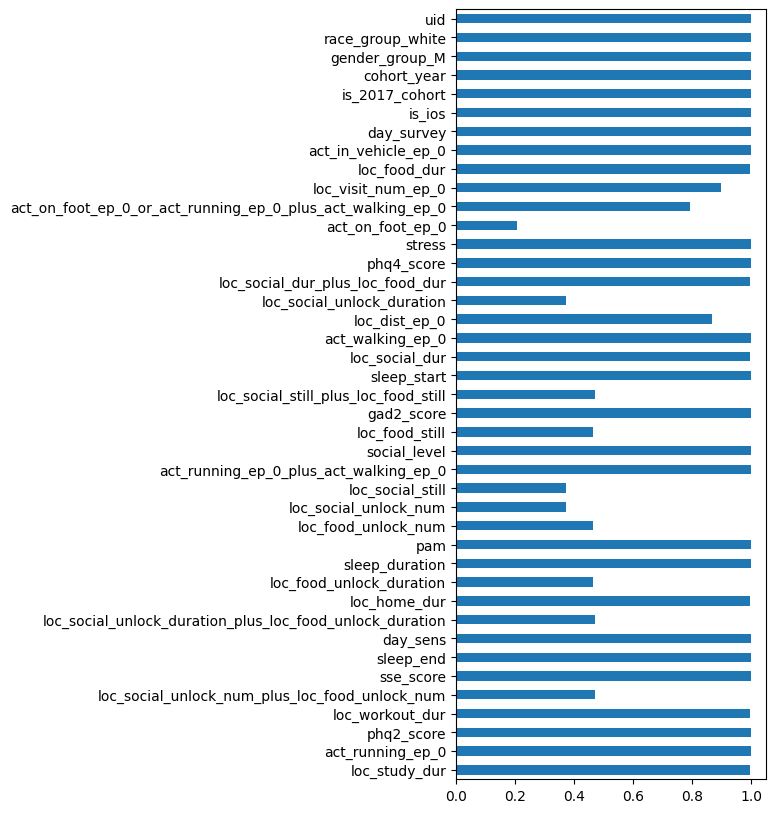

In [227]:
# null rate
ax = (1 - df.isnull().mean()).to_frame().plot.barh(figsize=(4, 10), legend=False)
ax.invert_yaxis()

In [228]:
check_df = pd.read_csv('features_v3.csv')
check_df

,uid,day_survey,Y1,Y2,Y3,Y4,Y5,Y6,Y7,D1,...,S1,S2,S3,S4,S5,S6,S7,Z1,Z2,Z3
0,003df5deff30e1e5a07b5d063fe85c3f,2017-10-06,7.0,0.0,0.0,0.0,4.0,17.0,1.0,0.0,...,251.4,5314.150918,1.292778,5.75,12.981969,8.770523,56.938186,9.150,39.6,112.8
1,003df5deff30e1e5a07b5d063fe85c3f,2017-10-13,7.0,0.0,0.0,0.0,4.0,17.0,1.0,0.0,...,125.7,4846.948206,1.618000,5.40,6.255514,7.336248,65.683645,5.575,47.4,92.0
2,003df5deff30e1e5a07b5d063fe85c3f,2017-10-14,7.0,0.0,0.0,0.0,5.0,17.0,1.0,0.0,...,125.7,4713.753968,1.668028,5.40,5.581952,7.418661,62.666138,5.800,45.4,91.8
3,003df5deff30e1e5a07b5d063fe85c3f,2017-10-16,4.0,0.0,0.0,0.0,1.0,17.0,1.0,0.0,...,1540.6,43788.508496,1.305028,5.10,6.046236,6.195268,62.442725,5.500,41.8,85.8
4,003df5deff30e1e5a07b5d063fe85c3f,2017-10-23,1.0,0.0,0.0,0.0,3.0,17.0,2.0,0.0,...,1540.6,43090.361687,0.928583,4.80,15.476544,12.130441,60.148926,5.275,50.0,92.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34701,ffc4b142e017c162ed4db7b05414fc4b,2021-12-18,13.0,0.0,0.0,0.0,3.0,13.0,2.0,0.0,...,1703.6,8560.195186,0.000000,1.80,NaN,NaN,NaN,6.500,39.2,91.2
34702,ffc4b142e017c162ed4db7b05414fc4b,2021-12-31,4.0,0.0,0.0,0.0,3.0,12.0,3.0,0.0,...,821.0,13369.742485,0.000000,1.50,NaN,NaN,NaN,5.850,54.6,101.4
34703,ffc4b142e017c162ed4db7b05414fc4b,2022-01-27,3.0,1.0,1.0,0.0,3.0,12.0,5.0,0.0,...,13.9,3000.404831,1.951542,3.80,36.099785,8.703598,67.220218,6.350,48.2,99.0
34704,ffc4b142e017c162ed4db7b05414fc4b,2022-01-30,3.0,0.0,0.0,0.0,2.0,12.0,3.0,0.0,...,18.9,3131.680285,1.626057,3.60,41.777185,13.130987,66.991643,6.425,47.8,99.2
